# Intro

{Fill in with information about this notebook}

# Set Up notebook 

In [33]:
def __check_parameter_names():
    #Check parameters are unique
    import inspect
    import w4h
    import pandas as pd
    function_list = [w4h.file_setup,
                 w4h.read_raw_csv,
                 w4h.define_dtypes,
                 w4h.read_study_area,
                 w4h.read_grid,
                 w4h.coords2geometry,
                 w4h.clip_gdf2study_area,
                 w4h.remove_nonlocated,
                 w4h.remove_no_topo,
                 w4h.remove_no_depth,
                 w4h.remove_bad_depth,
                 w4h.remove_no_formation,
                 w4h.get_search_terms,
                 w4h.read_dictionary_terms,
                 w4h.specific_define,
                 w4h.start_define,
                 w4h.wildcard_define,
                 w4h.depth_define,
                 w4h.fill_unclassified,
                 w4h.read_lithologies,
                 w4h.merge_lithologies,
                 w4h.align_rasters,
                 w4h.get_drift_thick,
                 w4h.sample_raster_points,
                 w4h.get_layer_depths,
                 w4h.layer_target_thick,
                 w4h.layer_interp,
                 w4h.export_grids]
    paramDF = pd.DataFrame()
    for f in function_list:
        currParamList = inspect.getfullargspec(f)[0]
        fList = []
        for p in currParamList:
            fList.append(f.__name__)
        currParamDF = pd.DataFrame({'Function':fList, 'Parameter':currParamList})
        paramDF = pd.concat([paramDF, currParamDF])

    uniqueDF = paramDF.drop_duplicates(subset='Parameter').copy()

    for up in uniqueDF['Parameter']:
        if up != 'verbose' and up!='log':
            matchDF = paramDF[paramDF['Parameter']==up].copy()
            if matchDF.shape[0] > 1:
                print(up)
                print(matchDF)

    #paramDF = paramDF[paramDF['Parameter']=='xcol']
    
    return uniqueDF
__check_parameter_names()

xcol
               Function Parameter
4          read_raw_csv      xcol
1       coords2geometry      xcol
2  sample_raster_points      xcol
8          layer_interp      xcol
ycol
               Function Parameter
5          read_raw_csv      ycol
2       coords2geometry      ycol
3  sample_raster_points      ycol
9          layer_interp      ycol
id_col
                Function Parameter
6           read_raw_csv    id_col
1  read_dictionary_terms    id_col
study_area_crs
          Function       Parameter
1  read_study_area  study_area_crs
5        read_grid  study_area_crs
no_data_val
              Function    Parameter
2            read_grid  no_data_val
2       remove_no_topo  no_data_val
3      remove_no_depth  no_data_val
2  remove_no_formation  no_data_val
2        align_rasters  no_data_val
study_area
              Function   Parameter
4            read_grid  study_area
0  clip_gdf2study_area  study_area
zcol
          Function Parameter
3  coords2geometry      zcol
1   remove_

,Function,Parameter
0,file_setup,well_data
1,file_setup,metadata
2,file_setup,data_filename
3,file_setup,metadata_filename
4,file_setup,log_dir
...,...,...
1,export_grids,out_path
2,export_grids,file_id
3,export_grids,filetype
4,export_grids,variable_sep


In [1]:
#Import modules
import numpy as np #Data manipulation
import pandas as pd #Point data manipulation and organization
import xarray as xr #Raster data manipulation and organization

import pathlib  #For filepaths, io, etc.
import os       #For several system-based commands
import datetime #For manipulation of time data, including file creation/modification times
import json     #For dictionary io, etc.

import matplotlib.pyplot as plt #For plotting and data vizualization
import geopandas as gpd         #For organization and manipulation of vector data in space (study area and some data points)
import rioxarray as rxr         #For orgnaization and manipulation of raster data
from scipy import interpolate
import shapely                  #For converting coordinates to point geometry
#Not sure if this cell is needed

In [3]:
#Scripts with functions made for this specific application
import w4h
import pathlib
import os
#Variables needed throughout, best to just assign now
todayDate, dateSuffix = w4h.get_current_date() 
repoDir = pathlib.Path(os.getcwd())

In [7]:
directoryDir = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\\'[:-1]
downholeDataPATH, headerDataPATH  = w4h.file_setup(db_dir=directoryDir, log_dir=r'C:\Users\riley\Desktop', verbose=True, log=True)
downholeDataIN, headerDataIN = w4h.read_raw_txt(data_filepath=downholeDataPATH, metadata_filepath=headerDataPATH, log=True) #Functions to read data into dataframes. Also excludes extraneous columns, and drops header data with no location information

Logging data to C:\Users\riley\Desktop\log_2023-06-03_13-22-04.txt
Most Recent version of this file is : ISGS_DOWNHOLE_DATA_2023-06-03.txt
Most Recent version of this file is : ISGS_HEADER_2023-06-03.txt
Most Recent version of this file is : xyzData.csv
Using the following files:
	 \\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\ISGS_DOWNHOLE_DATA_2023-06-03.txt
	 \\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\ISGS_HEADER_2023-06-03.txt
	 \\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\xyzData.csv


Most Recent version of this file is : ISGS_DOWNHOLE_DATA_2023-06-03.txt
Most Recent version of this file is : ISGS_HEADER_2023-06-03.txt
Using the following files:
	 \\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\WellData\RawWellData_OracleDatabase\TxtData\ISGS_DOWNHOLE_DATA_2023-06-03.txt
	 \\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\WellData\RawWellData_OracleDatabase\TxtData\ISGS_HEADER_2023-06-03.txt
Data file has 3079484 valid well records.
Metadata file has 637801 unique wells with valid location information.
3022963 records removed without location information.
56521 wells remain from 7213 geolocated wells in study area.
Well records removed: 793
Number of rows before dropping those without surface elevation information: 8182
Number of rows after dropping those without surface elevation information: 7389
Number of rows before dropping those without record depth information: 56521
Number of rows after dropping those without record depth information: 55937
Number of

c:\Users\riley\LocalData\Code\Github\wells4hydrogeology\w4h\clean.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[zcol].replace(no_data_val, np.nan, inplace=True)
c:\Users\riley\LocalData\Code\Github\wells4hydrogeology\w4h\clean.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[zcol], inplace=True)


Number of rows before dropping those without FORMATION information: 56521
Number of rows after dropping those without FORMATION information: 56521
Well records deleted: 0
Search terms to be used:
	 {} exact match term/definition pairs
	 {} starting match term/definition pairs
	 {} wildcard match term/definition pairs
Records Classified with full search term: 31715
Records Classified with full search term: 56.11% of data
24806 records unclassified; isolated into searchDF.
Start Term process should be done by 10:10


c:\Users\riley\LocalData\Code\Github\wells4hydrogeology\w4h\classify.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASS_FLAG'].where(~df[description_col].str.startswith(s,na=False),4,inplace=True)
c:\Users\riley\LocalData\Code\Github\wells4hydrogeology\w4h\classify.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LITHOLOGY'].where(~df[description_col].str.startswith(s,na=False),terms_df.loc[i,'LITHOLOGY'],inplace=True)


Records classified with start search term: 3591
Records classified with start search term: 14.48% of remaining data
21215 records unclassified; isolated into searchDF.
Wildcard Term process should be done by (?) 10:10
Records classified with wildcard search term: 0
Records classified with wildcard search term: 0.0% of remaining data
21215 records unclassified; isolated into searchDF.
Records classified as bedrock that were deeper than 550': 359
This represents 1.69% of the unclassified data in this dataframe.
Index(['API_NUMBER', 'TABLE_NAME', 'FORMATION', 'THICKNESS', 'TOP', 'BOTTOM',
       'LITHOLOGY', 'COLOR', 'CONSISTENCY', 'MOD1', 'MOD2', 'INTERPRETED',
       'COMPLETED', 'ORIGIN_INDIANA', 'SELECTED', 'SELECTED_TEMP',
       'SELECTED_UNDO', 'CLASS_FLAG', 'BEDROCK_FLAG'],
      dtype='object')
Index(['INTERPRETATION', 'TARGET'], dtype='object')
BEDROCK_ELEV_FT sampling should be done by 10:10
SURFACE_ELEV_FT sampling should be done by 10:10
BEDROCK_DEPTH_FT sampling should be do

([        API_NUMBER   LATITUDE  LONGITUDE  LATITUDE_PROJ  LONGITUDE_PROJ   TOP   
  0     1.362621e+07  38.733337 -89.933357   6.239983e+06    8.631196e+06   0.0  \
  1     9.309245e+08  38.778343 -89.915634   6.288818e+06    8.646505e+06   3.0   
  2     9.309249e+08  38.768166 -89.920731   1.046296e+07    1.440353e+07  16.0   
  3     9.309250e+08  38.755199 -89.913368   6.263660e+06    8.648318e+06   6.0   
  4     9.309253e+08  38.760735 -89.960236   6.269867e+06    8.608470e+06   0.0   
  ...            ...        ...        ...            ...             ...   ...   
  4392  1.374037e+09  38.561668 -90.208885   8.073221e+06    1.119364e+07   6.0   
  4393  1.374061e+09  38.554443 -89.994720   6.045855e+06    8.577909e+06   2.0   
  4394  1.374061e+09  38.555279 -89.996391   6.046770e+06    8.576489e+06   1.0   
  4395  1.374074e+09  38.528660 -90.244118   6.019288e+06    8.364877e+06   0.0   
  4396  1.374795e+09  38.640568 -90.051552   2.046573e+06    2.843328e+06   8.0   
  
 

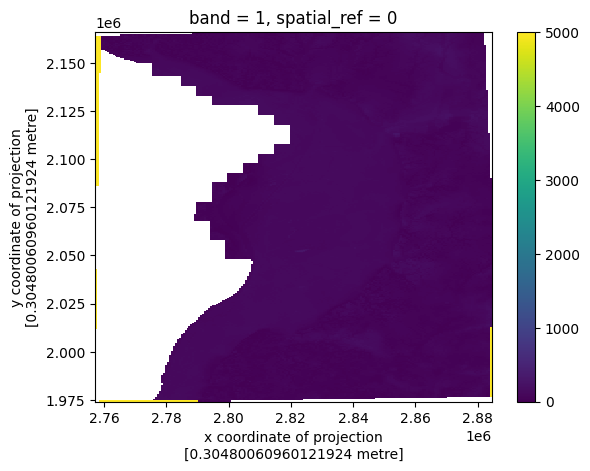

In [1]:
import w4h

dataDir = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\WellData\RawWellData_OracleDatabase\TxtData"

modelGridPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\grid_625_raster.tif"
surfaceElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ILStateLidar_ClipExtentESL.tif"
bedrockElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESLBedrock.tif"

studyAreaPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESL_StudyArea_5mi.shp"

specDictPath = r"C:\Users\riley\LocalData\Code\Github\wells4hydrogeology\resources\DICTIONARY_SearchTerms-Specific_2023-06-27.csv"
startDictPath = r"C:\Users\riley\LocalData\Code\Github\wells4hydrogeology\resources\SearchTerms-Start.csv"

targetPath = r"C:\Users\riley\LocalData\Code\Github\wells4hydrogeology\resources\Lithology_Interp_FineCoarse.csv"

procDir = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\ProcessedData\runTest"

w4h.run(well_data=dataDir,
        well_data_cols=None, 
        well_metadata=None, 
        well_metadata_cols=None, 
        layers=9,
        description_col='FORMATION', top_col='TOP', bottom_col='BOTTOM', depth_type='depth',
        study_area=studyAreaPath, xcol='LONGITUDE', ycol='LATITUDE', zcol='ELEVATION', idcol='API_NUMBER', output_crs='EPSG:4269',
        surf_elev_file=surfaceElevPath, bedrock_elev_file=bedrockElevPath, model_grid=modelGridPath,
        lith_dict=specDictPath, lith_dict_start=startDictPath, lith_dict_wildcard=None,
        target_dict=targetPath,
        export_dir=procDir,
        verbose=True,
        log=False,
        )

In [4]:
import pathlib

test = pathlib.Path()
test.is_file()

False

In [9]:
import pandas as pd

In [8]:
xyzDataIN = w4h.read_xyz(xyzpath=xyzInPATH, log=True)
downholeData = w4h.define_dtypes(df=downholeDataIN, dtype_file='downholeDataTypes.txt', log=True) #Define datatypes of each column of the new dataframes
headerData = w4h.define_dtypes(df=headerDataIN, dtype_file='headerDataTypes.txt', log=True)#Define datatypes of each column of the new dataframes
xyzData = w4h.define_dtypes(df=xyzDataIN, dtype_file='xyzDataTypes.txt', log=True)
studyAreaPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESL_StudyArea_5mi.shp"
studyAreaIN = w4h.read_study_area(studyareapath=studyAreaPath, log=True)
modelGridPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\grid_625_raster.tif"
surfaceElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ILStateLidar_ClipExtentESL.tif"
bedrockElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESLBedrock.tif"
modelGrid = w4h.read_grid(datapath=modelGridPath, grid_type='model', study_area=studyAreaIN,  read_grid=True, clip_to_studyarea=True, log=True)#, gridcrs='EPSG:26715', studyAreacrs='EPSG:26715')
surfaceElevGridIN = w4h.read_grid(datapath=surfaceElevPath, grid_type='surface', study_area=studyAreaIN, use_service=False, clip_to_studyarea=True, log=True)
bedrockElevGridIN = w4h.read_grid(datapath=bedrockElevPath, grid_type='bedrock', study_area=studyAreaIN, use_service=False, clip_to_studyarea=True, log=True)
#Code here for adding in control points
headerData = w4h.xyz_metadata_merge(xyz=xyzData, metadata=headerData, log=True) #This probably needs to be updated
headerData = w4h.coords2geometry(df=headerData, xcol='LONGITUDE', ycol='LATITUDE', crs='EPSG:4269', log=True)
headerData = w4h.clip_gdf2study_area(study_area=studyAreaIN, gdf=headerData, gdf_crs='EPSG:4269', log=True)
downholeData = w4h.remove_nonlocated(downholeData, headerData, log=True)
headerData = w4h.remove_no_topo(df=headerData, verbose=True, log=True)
donwholeData = w4h.drop_no_depth(downholeData, verbose=True, log=True) #Drop records with no depth information
donwholeData = w4h.drop_bad_depth(downholeData, verbose=True, log=True)#Drop records with bad depth information (i.e., top depth > bottom depth) (Also calculates thickness of each record)
downholeData = w4h.drop_no_formation(downholeData, verbose=True, log=True)
#downholeData.reset_index(inplace=True,drop=True) #These may not be necessary
#headerData.reset_index(inplace=True,drop=True) #These may not be necessary
downholeData = pd.merge(left = downholeData, right = headerData, on='API_NUMBER')

c:\Users\riley\.conda\envs\raster38\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Well records removed: 0
Number of rows before dropping those without surface elevation information: 8150
Number of rows after dropping those without surface elevation information: 8150
Number of rows before dropping those without record depth information: 56331
Number of rows after dropping those without record depth information: 55747
Number of well records without formation information deleted: 584
Number of rows before dropping those with obviously bad depth information: 56331
Number of rows after dropping those with obviously bad depth information: 55725
Well records deleted: 606
Number of rows before dropping those without FORMATION information: 56331
Number of rows after dropping those without FORMATION information: 56331
Well records deleted: 0


NameError: name 'pd' is not defined

In [12]:
specTermsPATH, startTermsPATH = w4h.get_search_terms(spec_dir=str(repoDir)+'/resources/', spec_glob_pattern='*SearchTerms-Specific*', start_glob_pattern='*SearchTerms-Start*', log=True)
specTerms = w4h.read_dictionary_terms(dict_file=specTermsPATH, log=True)
startTerms = w4h.read_dictionary_terms(dict_file=startTermsPATH, log=True)
oldDictPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\WellData\Dictionaries\DICTIONARY_Updated-06-2018.csv"
oldDict = w4h.read_dictionary_terms(dict_file=oldDictPath, cols={'DESCRIPTION':'FORMATION', 'LITHOLOGY':'INTERPRETATION'}, class_flag=1, log=True)

specTerms = pd.concat([specTerms, oldDict])
specTerms.drop_duplicates(subset='FORMATION', inplace=True)
specTerms.reset_index(inplace=True, drop=True)
downholeData = w4h.specific_define(downholeData, specTerms, verbose=True, log=True)
classifedDF, searchDF = w4h.split_defined(downholeData)
searchDF = w4h.start_define(df=searchDF, terms_df=startTerms, verbose=True)
downholeData = w4h.remerge_data(classifieddf=classifedDF, searchdf=searchDF)
classifedDF, searchDF = w4h.split_defined(downholeData)
searchDF = w4h.depth_define(searchDF, thresh=550, verbose=True, log=True)
downholeData = w4h.remerge_data(classifieddf=classifedDF, searchdf=searchDF)
downholeData = w4h.fill_unclassified(downholeData)
#dictDir = "\\\\isgs-sinkhole\\geophysics\\Balikian\\ISWS_HydroGeo\\WellDataAutoClassification\\SupportingDocs\\"
targetInterpDF = w4h.read_lithologies(log=True)
downholeData = w4h.merge_lithologies(df=downholeData, targinterps_df=targetInterpDF)
wellsDF = w4h.get_unique_wells(downholeData)
downholeData = w4h.sort_dataframe(df=downholeData, sort_cols=['API_NUMBER','TOP'], remove_nans=True)
inGrids = [bedrockElevGridIN, surfaceElevGridIN]
bedrockGrid, surfaceGrid = w4h.align_rasters(grids_unaligned=inGrids, modelgrid=modelGrid, log=True)
driftThickGrid, layerThickGrid = w4h.get_drift_thick(surface=surfaceGrid, bedrock=bedrockGrid, layers=9, plot=False, log=True)
headerData = w4h.sample_raster_points(raster=bedrockGrid, points_df=headerData, new_col='BEDROCK_ELEV_FT', log=True)
headerData = w4h.sample_raster_points(raster=surfaceGrid, points_df=headerData, new_col='SURFACE_ELEV_FT', log=True)
headerData = w4h.sample_raster_points(raster=driftThickGrid, points_df=headerData, new_col='BEDROCK_DEPTH_FT', log=True)
headerData = w4h.sample_raster_points(raster=layerThickGrid, points_df=headerData, new_col='LAYER_THICK_FT', log=True)
headerData = w4h.get_layer_depths(well_metadata=headerData, no_layers=9, log=True)
downholeData_layerInfo = w4h.merge_tables(data_df=downholeData,  data_cols=None, header_cols=None, header_df=headerData,on='API_NUMBER', how='inner', auto_pick_cols=True, log=True)
#downholeData = downholeData_layerInfo.copy()
resdf = w4h.layer_target_thick(downholeData_layerInfo, layers=9, outfile_prefix='CoarseFine', log=True)
layers_data = w4h.layer_interp(points=resdf, layers=9, grid=modelGrid, method='lin', log=True)

Most Recent version of this file is : SearchTerms-Specific_2022-11-16_essCols.csv
Most Recent version of this file is : SearchTerms-Start.csv
Records Classified with full search term: 31582
Records Classified with full search term: 56.07% of data
Start Term process should be done by 13:50


c:\Users\riley\LocalData\Github\wells4hydrogeology\w4h\classify.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASS_FLAG'].where(~df[description_col].str.startswith(s,na=False),4,inplace=True)
c:\Users\riley\LocalData\Github\wells4hydrogeology\w4h\classify.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTERPRETATION'].where(~df[description_col].str.startswith(s,na=False),terms_df.loc[i,'INTERPRETATION'],inplace=True)


Records classified with start search term: 3586
Records classified with start search term: 14.49% of remaining data
Records classified as bedrock that were deeper than 550': 359
This represents 1.7% of the unclassified data in this dataframe.
BEDROCK_ELEV_FT sampling should be done by 13:51
SURFACE_ELEV_FT sampling should be done by 13:51
BEDROCK_DEPTH_FT sampling should be done by 13:51
LAYER_THICK_FT sampling should be done by 13:51
REMOVING LATITUDE
REMOVING LONGITUDE
REMOVING ELEV_FT
REMOVING geometry
Completed interpolation for Layer 1
Completed interpolation for Layer 2
Completed interpolation for Layer 3
Completed interpolation for Layer 4
Completed interpolation for Layer 5
Completed interpolation for Layer 6
Completed interpolation for Layer 7
Completed interpolation for Layer 8
Completed interpolation for Layer 9


In [13]:
header_cols = ['API_NUMBER', 'LATITUDE', 'LONGITUDE', 'BEDROCK_ELEV_FT', 'SURFACE_ELEV_FT', 'BEDROCK_DEPTH_FT', 'LAYER_THICK_FT']
data_cols = downholeData.columns
on='API_NUMBER'
#Drop duplicate columns
drop_duplicate_cols=True
if drop_duplicate_cols:
    header_colCopy= header_cols.copy()
    remCount = 0
    for i, c in enumerate(header_colCopy):
        if c in data_cols and c != on:
            print('REMOVING', header_cols[i-remCount])
            header_cols.pop(i - remCount)
            remCount += 1

downholeData_layerInfo = pd.merge(left=downholeData, right=headerData,on='API_NUMBER', how='inner',)
#downholeData_layerInfo = w4h.merge_tables(data_df=downholeData,  data_cols=None, header_cols=None, header_df=headerData,on='API_NUMBER', how='inner', auto_pick_cols=True, log=True)

REMOVING LATITUDE
REMOVING LONGITUDE


In [14]:
downholeData_layerInfo=downholeData_layerInfo.rename(columns={'LATITUDE_y':"LATITUDE",'LONGITUDE_y':"LONGITUDE", 'geometry_y':'geometry'})
downholeData_layerInfo.columns

Index(['API_NUMBER', 'TABLE_NAME', 'FORMATION', 'THICKNESS', 'TOP', 'BOTTOM',
       'TOTAL_DEPTH_x', 'SECTION_x', 'TWP_x', 'TDIR_x', 'RNG_x', 'RDIR_x',
       'MERIDIAN_x', 'QUARTERS_x', 'ELEVATION_x', 'ELEVREF_x', 'COUNTY_CODE_x',
       'ELEVSOURCE_x', 'LATITUDE_x', 'LONGITUDE_x', 'ELEV_FT_x', 'geometry_x',
       'INTERPRETATION', 'CLASS_FLAG', 'BEDROCK_FLAG', 'TARGET',
       'TOTAL_DEPTH_y', 'SECTION_y', 'TWP_y', 'TDIR_y', 'RNG_y', 'RDIR_y',
       'MERIDIAN_y', 'QUARTERS_y', 'ELEVATION_y', 'ELEVREF_y', 'COUNTY_CODE_y',
       'ELEVSOURCE_y', 'LATITUDE', 'LONGITUDE', 'ELEV_FT_y', 'geometry',
       'LONGITUDE_PROJ', 'LATITUDE_PROJ', 'BEDROCK_ELEV_FT', 'SURFACE_ELEV_FT',
       'BEDROCK_DEPTH_FT', 'LAYER_THICK_FT', 'DEPTH_FT_LAYER1',
       'DEPTH_FT_LAYER2', 'DEPTH_FT_LAYER3', 'DEPTH_FT_LAYER4',
       'DEPTH_FT_LAYER5', 'DEPTH_FT_LAYER6', 'DEPTH_FT_LAYER7',
       'DEPTH_FT_LAYER8', 'DEPTH_FT_LAYER9', 'ELEV_FT_LAYER1',
       'ELEV_FT_LAYER2', 'ELEV_FT_LAYER3', 'ELEV_FT_LAYER4',

In [15]:
resdf = w4h.layer_target_thick(downholeData_layerInfo, layers=9, outfile_prefix='CoarseFine', log=True)

In [16]:
layers_data = w4h.layer_interp(points=resdf, layers=9, grid=modelGrid, method='nn', log=True)

Completed interpolation for Layer 1
Completed interpolation for Layer 2
Completed interpolation for Layer 3
Completed interpolation for Layer 4
Completed interpolation for Layer 5
Completed interpolation for Layer 6
Completed interpolation for Layer 7
Completed interpolation for Layer 8
Completed interpolation for Layer 9


In [17]:
out_dir=r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\ProcessedData"
w4h.export_grids(grid_data=layers_data, out_path=out_dir, file_id='',filetype='tif', variable_sep=True, date_stamp=True, log=False)

# END

In [53]:
#Export (rio)xarray dataarrays and datasets
def export_grids(grid_data, out_path, file_id='',filetype='tif', variable_sep=True, date_stamp=True):
    """Function to export grids to files.

    Parameters
    ----------
    grid_data : xarray DataArray or xarray Dataset
        Dataset or dataarray to be exported
    out_path : str or pathlib.Path object
        Output location for data export. If variable_sep=True, this should be a directory. Otherwise, this should also include the filename. The file extension should not be included here.
    filetype : str, optional
        Output filetype. Can either be pickle or any file extension supported by rioxarray.rio.to_raster(). Can either include period or not., by default 'tif'
    variable_sep : bool, optional
        If grid_data is an xarray Dataset, this will export each variable in the dataset as a separate file, including the variable name in the filename, by default False
    date_stamp : bool, optional
        Whether to include a date stamp in the file name., by default True
    """

    #Initialize lists to determine which filetype will be used for export
    ncdfList = ['netcdf', 'ncdf', 'n']
    tifList = ['tif', 'tiff', 'geotiff', 'geotif', 't']
    pickleList = ['pickle', 'pkl', 'p']

    #Format output string(s)
    #Format output filepath
    if type(out_path) is str or isinstance(out_path, pathlib.PurePath):
        if isinstance(out_path, pathlib.PurePath):
            pass
        else:
            out_path = pathlib.Path(out_path)
        if out_path.parent.exists()==False:
            print('Directory does not exist. Please enter a different value for the out_path parameter.')
            return        

        if out_path.is_dir():
            if isinstance(grid_data, xr.DataArray):
                if variable_sep:
                    lyrs = grid_data.coords['Layer'].values
                    filenames = []
                    for l in lyrs:
                        filenames.append('Layer'+str(l))
                else:
                    filenames = ['AllLayers']
            if isinstance(grid_data, xr.Dataset):
                if variable_sep:
                    filenames = []
                    for var in grid_data:
                        filenames.append(var)
                else:
                    filenames = ['AllLayers']    
        else:
            filenames = [out_path.stem]
            out_path = out_path.parent

    else:
        print('Please input string or pathlib object for out_path parameters')
        return
    
    #Format datestamp, if desired in output filename
    if date_stamp:
        todayDate = datetime.date.today()
        todayDateStr = '_'+str(todayDate)
    else:
        todayDateStr=''

    #Ensure the file suffix includes .
    if filetype[0] == '.':
        pass
    else:
        filetype = '.' + filetype

    if file_id != '':
        file_id = '_'+file_id

    out_path = out_path.as_posix()+'/'
    outPaths = []
    for f in filenames:
        outPaths.append(out_path+f+file_id+todayDateStr+filetype)

    #Do export
    if filetype.lower() in pickleList:
        import pickle
        for op in outPaths:
            try:
                with open(op, 'wb') as f:
                    pickle.dump(grid_data, f)
            except:
                print('An error occured during export.')
                print(op, 'could not be exported as a pickle object.')
                print('Try again using different parameters.')
    else:
        import rioxarray as rxr
        try:
            if isinstance(grid_data, xr.Dataset):
                if variable_sep:
                    for i, var in enumerate(grid_data.data_vars):
                        grid_data[var].rio.to_raster(outPaths[i])
                else:
                    grid_data.rio.to_raster(outPaths[0])
            elif isinstance(grid_data, xr.DataArray):
                if variable_sep:
                    lyrs = grid_data.coords['Layer'].values
                    for i, l in enumerate(lyrs):
                        out_grid = grid_data.sel(Layer = l).copy()
                        out_grid.rio.to_raster(outPaths[i])
                else:
                    grid_data.rio.to_raster(outPaths[0])
            else:
                grid_data.rio.to_raster(outPaths[0])
        except:
            print('An error occured during export.')
            print('{} could not be exported as {} file.'.format(outPaths, filetype))
            print('Try again using different parameters.')

    return


In [46]:
out_dir = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\ProcessedData"
out_dir = pathlib.Path(out_dir)
out_dir.parent

WindowsPath('//isgs-sinkhole.ad.uillinois.edu/geophysics/Balikian/ISWS_HydroGeo/WellDataAutoClassification')

In [54]:
out_dir = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\ProcessedData"
export_grids(grid_data=layers_data, out_path=out_dir, file_id='Coarse', filetype='tif', variable_sep=True, date_stamp=True)

In [ ]:
xyzDataIN = w4h.read_xyz(xyzpath=xyzInPATH, log=True)
downholeData = w4h.define_dtypes(df=downholeDataIN, dtype_file='downholeDataTypes.txt', log=True) #Define datatypes of each column of the new dataframes
headerData = w4h.define_dtypes(df=headerDataIN, dtype_file='headerDataTypes.txt', log=True)#Define datatypes of each column of the new dataframes
xyzData = w4h.define_dtypes(df=xyzDataIN, dtype_file='xyzDataTypes.txt', log=True)
studyAreaPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESL_StudyArea_5mi.shp"
studyAreaIN = w4h.read_study_area(studyareapath=studyAreaPath, log=True)
modelGridPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\grid_625_raster.tif"
surfaceElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ILStateLidar_ClipExtentESL.tif"
bedrockElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESLBedrock.tif"
modelGrid = w4h.read_grid(datapath=modelGridPath, grid_type='model', study_area=studyAreaIN,  read_grid=True, clip_to_studyarea=True, log=True)#, gridcrs='EPSG:26715', studyAreacrs='EPSG:26715')
surfaceElevGridIN = w4h.read_grid(datapath=surfaceElevPath, grid_type='surface', study_area=studyAreaIN, use_service=False, clip_to_studyarea=True, log=True)
bedrockElevGridIN = w4h.read_grid(datapath=bedrockElevPath, grid_type='bedrock', study_area=studyAreaIN, use_service=False, clip_to_studyarea=True, log=True)
#Code here for adding in control points
headerData = w4h.xyz_metadata_merge(xyz=xyzData, metadata=headerData, log=True) #This probably needs to be updated
headerData = w4h.coords2geometry(df=headerData, xcol='LONGITUDE', ycol='LATITUDE', crs='EPSG:4269', log=True)
headerData = w4h.clip_gdf2study_area(study_area=studyAreaIN, gdf=headerData, gdf_crs='EPSG:4269', log=True)
downholeData = w4h.remove_nonlocated(downholeData, headerData, log=True)
headerData = w4h.remove_no_topo(df=headerData, verbose=True, log=True)
donwholeData = w4h.drop_no_depth(downholeData, verbose=True, log=True) #Drop records with no depth information
donwholeData = w4h.drop_bad_depth(downholeData, verbose=True, log=True)#Drop records with bad depth information (i.e., top depth > bottom depth) (Also calculates thickness of each record)
downholeData = w4h.drop_no_formation(downholeData, verbose=True, log=True)
#downholeData.reset_index(inplace=True,drop=True) #These may not be necessary
#headerData.reset_index(inplace=True,drop=True) #These may not be necessary
downholeData = pd.merge(left = downholeData, right = headerData, on='API_NUMBER')